# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Thursday, March 5, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1l3JIXRCHWUfPZitXiCd90PQ2RhvnWmyx/view?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

For each of the columns ["age", "yredu", "capgain", "caploss", "workhr"], report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features ["age", "yredu", "capgain", "caploss", "workhr"] so that their values are always between 0 and 1. Make sure that you are actually modifying the dataframe df.


In [ ]:
print('Maximum age:', np.max(subdf["age"]) )
print('Minimum age:', np.min(subdf["age"]) )
print('Average age:', np.average(subdf["age"]) )
print('\n')
print('Maximum yredu:', np.max(subdf["yredu"]) )
print('Minimum yredu:', np.min(subdf["yredu"]) )
print('Average yredu:', np.average(subdf["yredu"]) )
print('\n')
print('Maximum capgain:', np.max(subdf["capgain"]) )
print('Minimum capgain:', np.min(subdf["capgain"]) )
print('Average capgain:', np.average(subdf["capgain"]) )
print('\n')
print('Maximum caploss:', np.max(subdf["caploss"]) )
print('Minimum caploss:', np.min(subdf["caploss"]) )
print('Average caploss:', np.average(subdf["caploss"]) )
print('\n')
print('Maximum workhr:', np.max(subdf["workhr"]) )
print('Minimum workhr:', np.min(subdf["workhr"]) )
print('Average workhr:', np.average(subdf["workhr"]) )

df["age"] = df["age"]/np.max(subdf["age"])
df["yredu"] = df["yredu"]/np.max(subdf["yredu"])
df["capgain"] = df["capgain"]/np.max(subdf["capgain"])
df["caploss"] = df["caploss"]/np.max(subdf["caploss"])
df["workhr"] = df["workhr"]/np.max(subdf["workhr"])

Maximum age: 90
Minimum age: 17
Average age: 38.58164675532078


Maximum yredu: 16
Minimum yredu: 1
Average yredu: 10.0806793403151


Maximum capgain: 99999
Minimum capgain: 0
Average capgain: 1077.6488437087312


Maximum caploss: 4356
Minimum caploss: 0
Average caploss: 87.303829734959


Maximum workhr: 99
Minimum workhr: 1
Average workhr: 40.437455852092995


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
ratiomales= (sum(df["sex"] == " Male")/df.shape[0])
percentage = ratiomales*100
print('Males:', percentage,'%')

ratiomales= (sum(df["sex"] == " Female")/df.shape[0])
percentage = ratiomales*100
print('Females:', percentage,'%')

Males: 66.92054912318419 %
Females: 33.07945087681583 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

print('Records that contained missing features: ', df_with_missing.shape[0])
print('Percentage of records removed: ', (df_with_missing.shape[0])/(df_with_missing.shape[0]+df_not_missing.shape[0]))


Records that contained missing features:  1843
Percentage of records removed:  0.056601455729246644


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
print(set(df_not_missing["work"]))

{' Without-pay', ' Federal-gov', ' State-gov', ' Local-gov', ' Private', ' Self-emp-inc', ' Self-emp-not-inc'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.433333,0.8125,0.02174,0.0,0.404040,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.555556,0.8125,0.00000,0.0,0.131313,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.422222,0.5625,0.00000,0.0,0.404040,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print(data.shape[1])

57


For each of the categories, if the values are discrete, then one hot encoding is used, for example, work_Federal_gov, work_Local_gov, work_Private are one hot encodings representing if the entry has a federal gov job, local gov job, or a private job which leads to 3 columns for "work" category/column. So, 57 comes from different combinations of each of the discrete options for each category/column.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)


def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`  I THINK U MEAN get_onehot not get_range
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """

    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    i=np.argmax(onehot)
    return cat_values[feature][i]


#test:
print(get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work"))
print(get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work"))

State-gov
Private


In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
np.random.shuffle(datanp)

train_index = int(datanp.shape[0] * 0.7)
val_index = int(datanp.shape[0] * 0.85)

train_set = datanp[:train_index]
val_set = datanp[train_index:val_index]
test_set = datanp[val_index:]

print("# Train Set: " + str(train_set.shape[0]))
print("# Test Set: " + str(val_set.shape[0]))
print("# Val Set: " + str(test_set.shape[0]))

# Train Set: 21502
# Test Set: 4608
# Val Set: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 40), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(40, 20)
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 40), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(40, 57), 
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

To normalize the values to [0,1] to keep consistency with the original values. 

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, val_acc, epochs, val_loss, train_loss = [], [], [], [], []

    for epoch in range(num_epochs):
      val = 0
      total_loss=0
      for data in train_loader:
          datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
          recon = model(datam)
          loss = criterion(recon, data)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          total_loss += loss.item()
          val +=1
        
      train_loss.append(float(total_loss) / (val + 1))
      

      trainacc = get_accuracy(model, train_loader)
      validacc = get_accuracy(model, valid_loader)
      print("training acc: ", trainacc)
      print("validation acc: ", validacc)
      train_acc.append(trainacc)
      val_acc.append(validacc)
      epochs.append(epoch)

      val = 0
      total_loss=0
      for data in valid_loader:
        datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
        recon = model(datam)
        loss = criterion(recon, data)
        
        total_loss += loss.item()
        val +=1
        
      val_loss.append(float(total_loss) / (val + 1))

    plt.title("Training Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.xlabel("epoch")
    plt.ylabel("Training Accuracy")
    plt.show()

    plt.title("Validation Accuracy")
    plt.plot(epochs, train_acc, label="Validation")
    plt.xlabel("epoch")
    plt.ylabel("Validation Accuracy")
    plt.show()

    # #Plotting Loss
    plt.title("Train vs Validation Loss")
    plt.plot(epochs, train_loss, label="Train")
    plt.plot(epochs, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total


### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

training acc:  0.4038151489783896
validation acc:  0.40357349537037035
training acc:  0.46470870926735497
validation acc:  0.4625651041666667
training acc:  0.4694369516014014
validation acc:  0.4675925925925926
training acc:  0.5121771618144049
validation acc:  0.5126229745370371
training acc:  0.5385778067156544
validation acc:  0.5402560763888888
training acc:  0.5506309490590022
validation acc:  0.5517939814814815
training acc:  0.558110873407125
validation acc:  0.5601490162037037
training acc:  0.5630639010324621
validation acc:  0.5652488425925926
training acc:  0.5701252596657675
validation acc:  0.5712167245370371
training acc:  0.5782175301522339
validation acc:  0.5790653935185185
training acc:  0.5856354447648281
validation acc:  0.5869864004629629
training acc:  0.5884413852974917
validation acc:  0.5904224537037037
training acc:  0.5924797693237839
validation acc:  0.5924840856481481
training acc:  0.5984482063683998
validation acc:  0.5971860532407407
training acc:  0.60

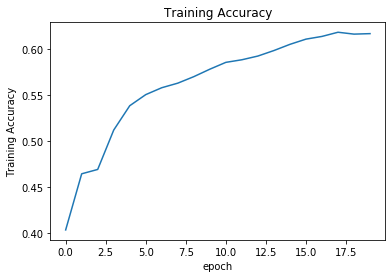

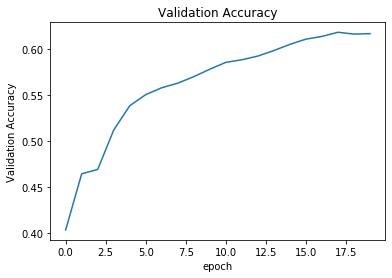

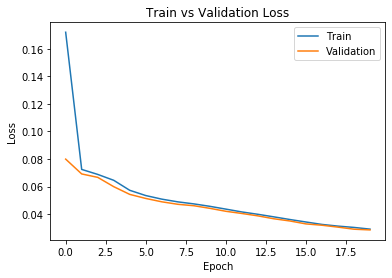

In [ ]:
batch_size=64 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

autoencoder = AutoEncoder()
train(autoencoder, train_loader, valid_loader, num_epochs=20, learning_rate=1e-4)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

Firstly, the learning rate was changed to 0.001 and it was observed that the final accuracy for training and validation are higher. Further, loss decreases faster and the final loss value is also lower with the higher learning rate. Further, it was investigated whether a lower learning rate would yield better results. However, it was found that the final accuracy is lower and loss is higher with a lower learning rate. 
Secondly, the effect of batch size was examined. The model was trained with both batch size 16 and 128, however and much of a difference in terms of accuracy and loss was not noticed. Therefore, changing the learning rate to 0.001 was an optimal choice for tuning hyperparameters.

**Learning rate**

training acc:  0.5657923293957151
validation acc:  0.5660807291666666
training acc:  0.6090983784454159
validation acc:  0.6089409722222222
training acc:  0.6086178029950702
validation acc:  0.6027199074074074
training acc:  0.6129274796142995
validation acc:  0.6115451388888888
training acc:  0.6220429107369857
validation acc:  0.6178023726851852
training acc:  0.6268021579387963
validation acc:  0.6234809027777778
training acc:  0.6273602455585527
validation acc:  0.6229383680555556
training acc:  0.6277555576225468
validation acc:  0.6233362268518519
training acc:  0.6314761417542554
validation acc:  0.6260850694444444
training acc:  0.6319024586860137
validation acc:  0.6285445601851852
training acc:  0.6339875360431588
validation acc:  0.6285445601851852
training acc:  0.6353750038756085
validation acc:  0.6302083333333334
training acc:  0.6401109974265959
validation acc:  0.6366825810185185
training acc:  0.6391343440920224
validation acc:  0.6357421875
training acc:  0.643521532

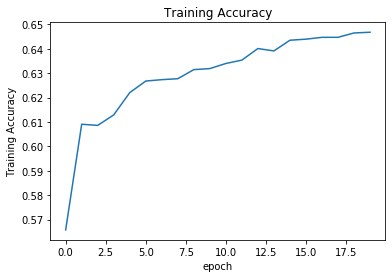

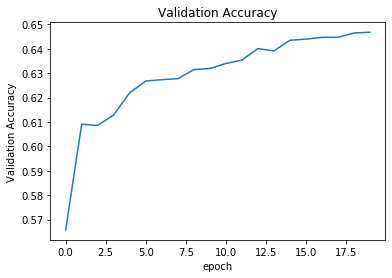

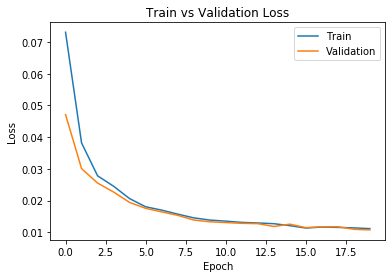

In [ ]:
batch_size=64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

autoencoder = AutoEncoder()
train(autoencoder, train_loader, valid_loader, num_epochs=20, learning_rate=0.001)

training acc:  0.44266424828698103
validation acc:  0.44144241898148145
training acc:  0.4519812110501349
validation acc:  0.4506293402777778
training acc:  0.46071683254270923
validation acc:  0.45912905092592593
training acc:  0.5149365950454221
validation acc:  0.5134910300925926
training acc:  0.5290128050103866
validation acc:  0.5298755787037037
training acc:  0.5412984838619663
validation acc:  0.5423177083333334
training acc:  0.5506774563606486
validation acc:  0.5525173611111112
training acc:  0.5658853439990078
validation acc:  0.5641637731481481
training acc:  0.568761045484141
validation acc:  0.5683955439814815
training acc:  0.5732334976591325
validation acc:  0.5735677083333334
training acc:  0.5759386723715624
validation acc:  0.5743634259259259
training acc:  0.5863485567234056
validation acc:  0.5835141782407407
training acc:  0.5944950857284593
validation acc:  0.5914713541666666
training acc:  0.6007735714507177
validation acc:  0.5988859953703703
training acc:  0.

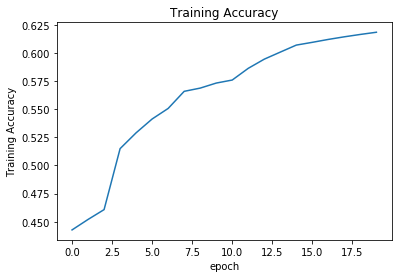

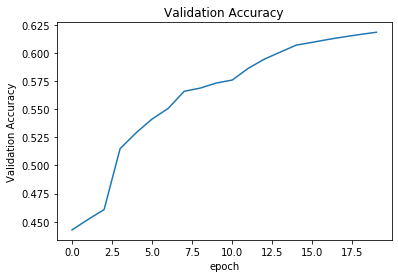

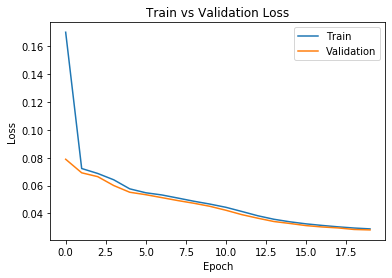

In [ ]:
batch_size=64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

autoencoder = AutoEncoder()
train(autoencoder, train_loader, valid_loader, num_epochs=20, learning_rate=1e-5)

**Batch Size**

training acc:  0.46325923169937683
validation acc:  0.46242042824074076
training acc:  0.5484683595324465
validation acc:  0.5491174768518519
training acc:  0.5705825814652901
validation acc:  0.5716869212962963
training acc:  0.5884646389483149
validation acc:  0.5853949652777778
training acc:  0.604308126375841
validation acc:  0.6021412037037037
training acc:  0.6171131367624717
validation acc:  0.6151258680555556
training acc:  0.6160744736923697
validation acc:  0.6129557291666666
training acc:  0.6170821318947075
validation acc:  0.6134620949074074
training acc:  0.6167410783493008
validation acc:  0.6099898726851852
training acc:  0.6137181037422875
validation acc:  0.6096281828703703
training acc:  0.6122763773912504
validation acc:  0.6080367476851852
training acc:  0.6141211670232226
validation acc:  0.6094473379629629
training acc:  0.614167674324869
validation acc:  0.6094111689814815
training acc:  0.6157566737977862
validation acc:  0.6098813657407407
training acc:  0.619

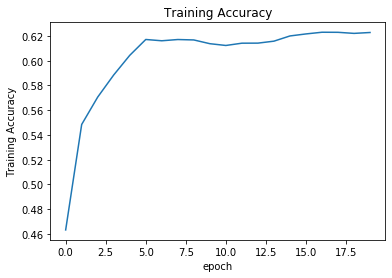

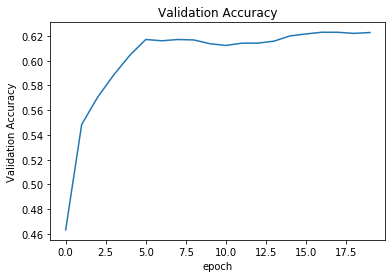

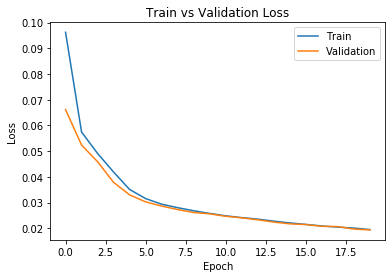

In [ ]:
batch_size=16
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

autoencoder = AutoEncoder()
train(autoencoder, train_loader, valid_loader, num_epochs=20, learning_rate=1e-4)

training acc:  0.44264099463615786
validation acc:  0.44144241898148145
training acc:  0.45187269401296004
validation acc:  0.45044849537037035
training acc:  0.4595463987846092
validation acc:  0.4586588541666667
training acc:  0.5132545809692122
validation acc:  0.5112847222222222
training acc:  0.5275478250085264
validation acc:  0.5287181712962963
training acc:  0.5415620252379624
validation acc:  0.5432219328703703
training acc:  0.5505379344557095
validation acc:  0.5516493055555556
training acc:  0.5645521346851455
validation acc:  0.5636212384259259
training acc:  0.5674820946888661
validation acc:  0.5665870949074074
training acc:  0.571613493318451
validation acc:  0.5726996527777778
training acc:  0.5736133072892444
validation acc:  0.5732060185185185
training acc:  0.5864415713266983
validation acc:  0.5843460648148148
training acc:  0.5923014913341395
validation acc:  0.5898799189814815
training acc:  0.6015021858431774
validation acc:  0.5995370370370371
training acc:  0.

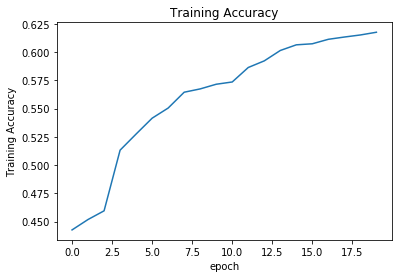

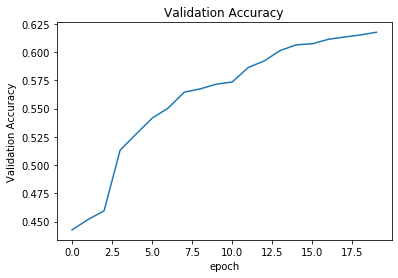

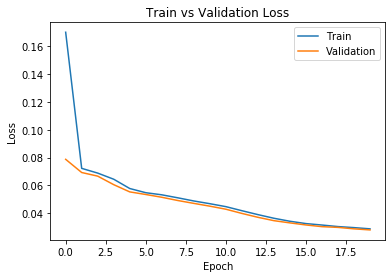

In [ ]:
batch_size=128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

autoencoder = AutoEncoder()
train(autoencoder, train_loader, valid_loader, num_epochs=20, learning_rate=1e-4)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
batch_size=64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

autoencoder = AutoEncoder()
train(autoencoder, train_loader, valid_loader, num_epochs=20, learning_rate=0.001)

In [ ]:
print(get_accuracy(autoencoder, test_loader))

0.6453631365740741


Based on the tuned hyperparameter (learning rate changed to 0.001), the test data set accuracy is 64.536%

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
def get_accuracy_baseline(data_loader):

    total = 0
    acc = 0
    mostcommon =''
    for col in catcols:

      if col == 'work':
        mostcommon= 'Private'
      if col == 'marriage':
        mostcommon= 'Married-civ-spouse'
      if col == 'occupation':
        mostcommon= 'Prof-specialty'
      if col == 'edu':
        mostcommon= 'HS-grad'
      if col == 'relationship':
        mostcommon= 'Husband'
      if col == 'sex':
        mostcommon= 'Male'

      for item in data_loader: # minibatches
          inp = item.detach().numpy()
          for i in range(inp.shape[0]): # record in minibatch
              acc += int(mostcommon == get_feature(inp[i], col))
              total += 1
      
    return acc / total

print(get_accuracy_baseline(test_loader))

0.4568504050925926


The test accuracy for the baseline model is 45.685%

### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

Test accuracy of my model is higher than the baseline model. My model's test accuracy was 64.7% compared to 45.685% percent of the baseline model. This is because there is no algorithmic logic or predictive analysis in the baseline model, so it yields worse results

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
#first item in test data

for item in test_loader:
  inp = item.detach().numpy()
  for col in catcols:
    print(col + ':' + get_feature(inp[0], col))
  break

work:Private
marriage:Divorced
occupation:Prof-specialty
edu:Bachelors
relationship:Not-in-family
sex:Male


No, it doesnt seem reasonable to guess this person's education based on their other features. This is because other categories do not seem to be predictive/indicative of their education.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
def partE(model, data_loader):
 
    for item in data_loader: # minibatches
        inp = item.detach().numpy()
        out = model(zero_out_feature(item.clone(), 'edu')).detach().numpy()
        print(get_feature(inp[0], 'edu'))
        break


partE(autoencoder, test_loader)
            



Bachelors


My model predicts "Bachelors" for the education of this person.

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

The baseline model always predicts the most common element in each category, so it would output HS-grad. 